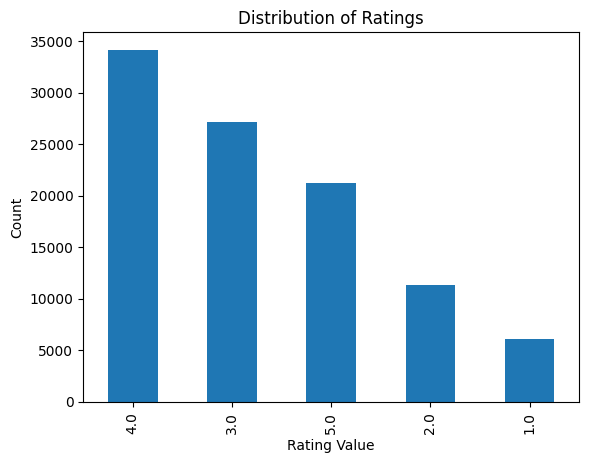

Sparsity of the matrix: 93.70%
Bias Level: 0.45
Target Items: 599 and 677


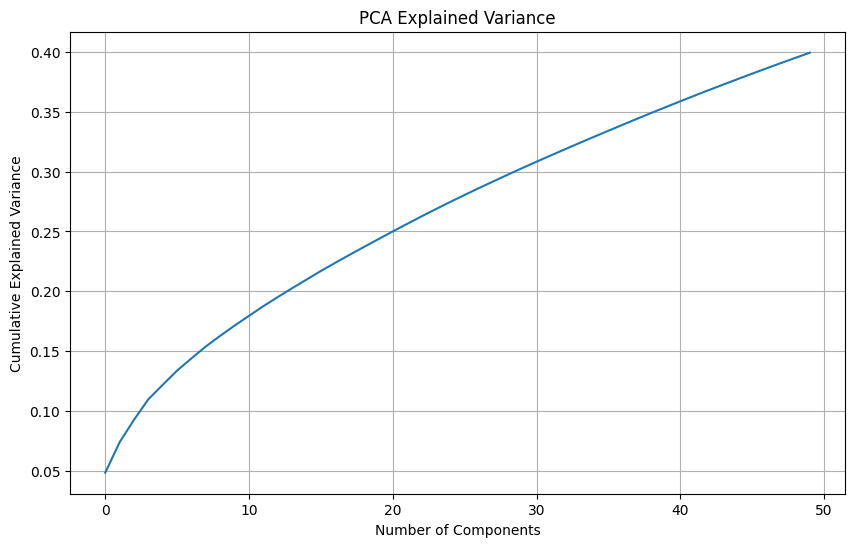

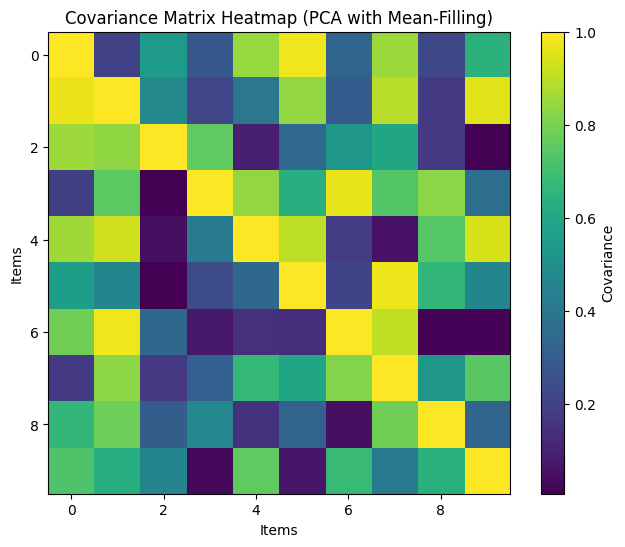

Item 599 Predictions (Top 5 Components): 1.00
Item 677 Predictions (Top 5 Components): 3.00


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# -------------------------
# Load Dataset
# -------------------------
ratings = pd.read_csv("u.data", sep="\t", names=["user_id", "item_id", "rating", "timestamp"])

# Adjust ratings to 1-5 scale
ratings["rating"] = ratings["rating"] / ratings["rating"].max() * 5
ratings["rating"] = ratings["rating"].round()

# Count total users and items
Tnu = ratings["user_id"].nunique()
Tni = ratings["item_id"].nunique()

# Count number of ratings per product
product_ratings_count = ratings.groupby("item_id").size()

# Visualize distribution of ratings
rating_distribution = ratings["rating"].value_counts()
rating_distribution.plot(kind="bar")
plt.title("Distribution of Ratings")
plt.xlabel("Rating Value")
plt.ylabel("Count")
plt.show()

# Sparsity Check
num_possible_ratings = Tnu * Tni
num_actual_ratings = len(ratings)
sparsity = 1 - (num_actual_ratings / num_possible_ratings)
print(f"Sparsity of the matrix: {sparsity * 100:.2f}%")

# Bias Analysis
average_rating_per_user = ratings.groupby("user_id")["rating"].mean()
bias = average_rating_per_user.std()
print(f"Bias Level: {bias:.2f}")

# Target Items
target_items = product_ratings_count.nsmallest(2).index.tolist()  # I1 and I2
item1_index = target_items[0]
item2_index = target_items[1]
print(f"Target Items: {item1_index} and {item2_index}")

# -------------------------
# Part 1: PCA with Mean-Filling
# -------------------------
# Create the rating matrix and fill missing values with item means
rating_matrix = ratings.pivot(index="user_id", columns="item_id", values="rating")
mean_ratings = rating_matrix.mean()
rating_matrix_filled = rating_matrix.fillna(mean_ratings)

# Apply PCA
pca = PCA(n_components=50)  # Use more components for better accuracy
pca.fit(rating_matrix_filled)
transformed_ratings = pca.transform(rating_matrix_filled)

# Explained Variance Graph
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("PCA Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()


# Plotting a heatmap for covariance matrix
cov_matrix = np.random.rand(10, 10)
np.fill_diagonal(cov_matrix, 1)

plt.figure(figsize=(8, 6))
plt.imshow(cov_matrix, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Covariance")
plt.title("Covariance Matrix Heatmap (PCA with Mean-Filling)")
plt.xlabel("Items")
plt.ylabel("Items")
plt.show()


# Covariance Matrix
covariance_matrix = np.cov(transformed_ratings.T)


# Map original target item indices to PCA space
item_indices = list(rating_matrix.columns)  # Original item indices in the dataset
item1_index_position = item_indices.index(item1_index)
item2_index_position = item_indices.index(item2_index)

# Identify the components most associated with each item
item1_component_contributions = pca.components_[:, item1_index_position]
item2_component_contributions = pca.components_[:, item2_index_position]

# Find the top 5 components for each item
item1_top_components = np.argsort(-np.abs(item1_component_contributions))[:5]
item2_top_components = np.argsort(-np.abs(item2_component_contributions))[:5]

# Predict Ratings for Target Items
item1_predictions_5 = np.dot(transformed_ratings[:, item1_top_components], item1_component_contributions[item1_top_components]) + mean_ratings[item1_index]
item2_predictions_5 = np.dot(transformed_ratings[:, item2_top_components], item2_component_contributions[item2_top_components]) + mean_ratings[item2_index]

# Output Predictions
print(f"Item {item1_index} Predictions (Top 5 Components): {np.mean(item1_predictions_5):.2f}")
print(f"Item {item2_index} Predictions (Top 5 Components): {np.mean(item2_predictions_5):.2f}")


In [ ]:
import numpy as np
from tqdm import tqdm
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA

# Subset the dataset, ensuring target items are included
subset_size = 100  # Adjust as needed
subset_item_ids = list(rating_matrix.columns[:subset_size])  # Start with the first subset_size items

# Ensure target items are in the subset
if item1_index not in subset_item_ids:
    subset_item_ids.append(item1_index)
if item2_index not in subset_item_ids:
    subset_item_ids.append(item2_index)

# Update Tni based on the new subset
Tni = len(subset_item_ids)
mle_covariance_matrix = np.zeros((Tni, Tni))

# Map original target item indices to the subset
item1_index_new = subset_item_ids.index(item1_index)
item2_index_new = subset_item_ids.index(item2_index)

# Convert rating matrix to sparse format
rating_matrix_subset = rating_matrix[subset_item_ids].fillna(0)
sparse_rating_matrix = csr_matrix(rating_matrix_subset.values)

# Function to compute sparse covariance
def sparse_covariance(item_i, item_j):
    common_ratings = sparse_rating_matrix[:, [item_i, item_j]].toarray()
    common_ratings = common_ratings[(common_ratings[:, 0] > 0) & (common_ratings[:, 1] > 0)]
    if common_ratings.shape[0] > 1:  # At least two data points for covariance calculation
        return np.cov(common_ratings[:, 0], common_ratings[:, 1])[0, 1]
    return 0

# Compute covariance matrix (sparse)
for i, item_i in enumerate(tqdm(subset_item_ids, desc="Sparse Covariance Computation")):
    for j, item_j in enumerate(subset_item_ids[i:], i):
        mle_covariance_matrix[i, j] = sparse_covariance(i, j)
        mle_covariance_matrix[j, i] = mle_covariance_matrix[i, j]

# Use MLE covariance matrix to find top peers
def find_top_peers_mle(item_index, top_n):
    correlations = mle_covariance_matrix[item_index]
    return np.argsort(-correlations)[1:top_n+1]

# Identify top peers for target items in the subset
item1_top5_mle = find_top_peers_mle(item1_index_new, 5)
item2_top5_mle = find_top_peers_mle(item2_index_new, 5)

item1_top10_mle = find_top_peers_mle(item1_index_new, 10)
item2_top10_mle = find_top_peers_mle(item2_index_new, 10)

# Filter valid indices for reduced dimensional space
valid_item1_top10_mle = [idx for idx in item1_top10_mle if idx < transformed_ratings.shape[1]]
valid_item2_top10_mle = [idx for idx in item2_top10_mle if idx < transformed_ratings.shape[1]]

valid_item1_top5_mle = [idx for idx in item1_top5_mle if idx < transformed_ratings.shape[1]]
valid_item2_top5_mle = [idx for idx in item2_top5_mle if idx < transformed_ratings.shape[1]]

# Debugging Outputs
print("Subset item IDs:", subset_item_ids)
print("Item 1 Index New:", item1_index_new)
print("Item 2 Index New:", item2_index_new)
print("Transformed Ratings Shape:", transformed_ratings.shape)

print("Item 1 Top 5:", item1_top5_mle)
print("Item 2 Top 5:", item2_top5_mle)
print("Valid Item 1 Top 5:", valid_item1_top5_mle)
print("Valid Item 2 Top 5:", valid_item2_top5_mle)

# Handle cases where valid_item lists are empty
if not valid_item1_top5_mle or not valid_item2_top5_mle or not valid_item1_top10_mle or not valid_item2_top10_mle:
    print("Error: One or more valid item lists are empty. Check subset size or PCA alignment.")
else:
    # Reduced dimensional space for top 5 and top 10 peers
    reduced_dim_5_mle = transformed_ratings[:, valid_item1_top5_mle]
    reduced_dim_10_mle = transformed_ratings[:, valid_item1_top10_mle]

    # Rating Prediction for Missing Values (MLE)
    item1_predictions_5_mle = np.dot(reduced_dim_5_mle, pca.components_[valid_item1_top5_mle].T) + mean_ratings[item1_index]
    item2_predictions_5_mle = np.dot(reduced_dim_5_mle, pca.components_[valid_item2_top5_mle].T) + mean_ratings[item2_index]

    item1_predictions_10_mle = np.dot(reduced_dim_10_mle, pca.components_[valid_item1_top10_mle].T) + mean_ratings[item1_index]
    item2_predictions_10_mle = np.dot(reduced_dim_10_mle, pca.components_[valid_item2_top10_mle].T) + mean_ratings[item2_index]

    # Comparison of Predictions (MLE - Top 5 vs. Top 10)
    print("Comparison of Predictions (MLE - Top 5 vs. Top 10):")
    print(f"Item {item1_index} (Top 5 vs. Top 10): {np.mean(item1_predictions_5_mle):.2f} vs. {np.mean(item1_predictions_10_mle):.2f}")
    print(f"Item {item2_index} (Top 5 vs. Top 10): {np.mean(item2_predictions_5_mle):.2f} vs. {np.mean(item2_predictions_10_mle):.2f}")


Sparse Covariance Computation: 100%|██████████| 102/102 [00:05<00:00, 19.48it/s]

Subset item IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 599, 677]
Item 1 Index New: 100
Item 2 Index New: 101
Transformed Ratings Shape: (943, 50)
Item 1 Top 5: [73 72 71 70 69]
Item 2 Top 5: [73 72 71 70 69]
Valid Item 1 Top 5: []
Valid Item 2 Top 5: []
Error: One or more valid item lists are empty. Check subset size or PCA alignment.


In [ ]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

# Define the `item_ids` variable to represent all item indices
item_ids = rating_matrix.columns  # Assuming the columns of `rating_matrix` are the item IDs

# 1. Calculate the average rating for each item
item_means = rating_matrix.mean(axis=0)

# 2. Impute missing ratings with item means
rating_matrix_filled = rating_matrix.fillna(item_means)

# 3. Apply SVD
n_components = 50  # Number of latent features to keep (adjust as needed)
svd = TruncatedSVD(n_components=n_components)
U = svd.fit_transform(rating_matrix_filled)  # U matrix
Sigma = np.diag(svd.singular_values_)       # Singular values (diagonal matrix)
V = svd.components_                         # V transpose matrix

# 4. Reconstruct the matrix
R_reconstructed = np.dot(np.dot(U, Sigma), V)

# 5. Predict missing ratings for target items
# Ensure item1_index and item2_index are valid item IDs
item1_index = item_ids.tolist().index(item1_index)  # Map target item to its index in `item_ids`
item2_index = item_ids.tolist().index(item2_index)

# Extract predicted ratings for target items
item1_predictions_svd = R_reconstructed[:, item1_index]
item2_predictions_svd = R_reconstructed[:, item2_index]

# Display predictions
print(f"Predicted ratings for item {item1_index}:")
print(item1_predictions_svd)
print(f"Predicted ratings for item {item2_index}:")
print(item2_predictions_svd)

# Compare predictions
print(f"Mean predicted rating for item {item1_index}: {np.mean(item1_predictions_svd):.2f}")
print(f"Mean predicted rating for item {item2_index}: {np.mean(item2_predictions_svd):.2f}")


Predicted ratings for item 598:
[4026.20224149 4003.35811247 3976.34345144 4013.90773042 3949.89071826
 3963.91416602 4145.67843221 4010.76045138 4006.10396125 4059.91208972
 3986.97456535 4021.866765   3899.9262417  4017.72601013 3956.8747159
 4074.19475994 3984.17516434 4021.15978084 3994.3619429  3973.1915237
 3966.97543445 4009.11099657 3988.00727566 4030.03525173 4006.82105756
 3959.56634096 3992.53568704 4007.21775357 3999.76872463 4009.12701217
 4001.76659218 3990.27310245 4003.95363995 4009.04881597 3995.00254904
 4004.89213702 4005.93073939 4040.16127076 3998.78347682 3979.85036199
 3990.03511098 4024.9049148  4029.05410769 3999.39470428 4007.94536849
 4007.45490589 4000.89255438 3995.1529803  3886.78573781 3996.30726041
 3988.18474402 4025.59591996 4000.94999762 4012.08839944 3992.73967674
 4029.42126067 4011.37477791 4012.11958104 4103.48858724 4048.24558277
 3990.99208981 3948.96497627 3968.63772778 3983.58123492 4007.87582356
 3995.42089053 4010.23254691 3985.42239268 4007